1. Add Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import time as ti
from google.colab import drive
%matplotlib inline

# DATA Preparation

In [ ]:
drive.mount('/content/gdrive')
!cd '/content/gdrive/My Drive/'


Mounted at /content/gdrive


In [ ]:
# Read the data From Google Drive
df = pd.read_csv("gdrive/My Drive/GCNIDS_Improvement/gear_dataset.csv")
df.columns = ['Timestamp','CAN_ID','Data byte','data_1','data_2','data_3','data_4','data_5','data_6','data_7','data_8','attack_flag']
df = df.drop('Timestamp', axis=1)
# Clearing The Data
#df = df[['CAN_ID','Data byte','attack_flag']]
df['attack_flag'][df["attack_flag"] == "R"] = 0
df['attack_flag'][df["attack_flag"] == "T"] = 1
df['attack_flag'] = df['attack_flag'].fillna(0)
df['CAN_ID'] = df['CAN_ID'].fillna("0000")
df['Data byte'] = df['Data byte'].fillna(8)
df['data_3'][df['data_3']== 'R'] = np.nan
df[["data_1","data_2","data_3","data_4","data_5","data_6","data_7","data_8"]] = df[["data_1","data_2","data_3","data_4","data_5","data_6","data_7","data_8"]].fillna("00")

df['data_1'] = df['data_1'].apply(int, base=16)

df['data_2'] = df['data_2'].apply(int, base=16)

df['data_3'] = df['data_3'].apply(int, base=16)

df['data_4'] = df['data_4'].apply(int, base=16)

df['data_5'] = df['data_5'].apply(int, base=16)

df['data_6'] = df['data_6'].apply(int, base=16)

df['data_7'] = df['data_7'].apply(int, base=16)

df['data_8'] = df['data_8'].apply(int, base=16)

# allocate Unique ID int instead of Hex String
unique_ids = df['CAN_ID'].unique()

# Create a mapping dictionary
id_mapping = {id: idx + 1 for idx, id in enumerate(unique_ids)}

# Map hexadecimal IDs to integer values
df['CAN_ID'] = df['CAN_ID'].map(id_mapping)

#select the more attackness Area
df = df.drop(index=df.index[2000000:])
df = df.drop(index=df.index[:1000000])
df

<ipython-input-3-92b3c9318ee6>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['attack_flag'][df["attack_flag"] == "R"] = 0
<ipython-input-3-92b3c9318ee6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['attack_flag'][df["attack_flag"] == "T"] = 1
<ipython-input-3-92b3c9318ee6>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['data_3'][df['data_3']== 'R'] = np.nan


,CAN_ID,Data byte,data_1,data_2,data_3,data_4,data_5,data_6,data_7,data_8,attack_flag
1000000,4,8,1,69,96,255,107,0,0,0,1
1000001,19,8,0,0,0,0,0,0,0,0,0
1000002,20,8,8,0,0,0,0,0,0,0,0
1000003,9,8,0,33,16,255,0,255,0,0,0
1000004,8,8,0,0,0,0,0,3,4,170,0
...,...,...,...,...,...,...,...,...,...,...,...
1999995,11,8,7,128,0,255,4,128,12,209,0
1999996,12,8,247,127,0,0,82,127,12,235,0
1999997,13,8,0,0,0,0,6,39,44,152,0
1999998,1,8,21,0,0,0,0,0,0,0,0


In [ ]:
"""values = df.values
groups = [0,1,2,3,4,5,6,7,8,9,10]
i = 1
plt.figure(figsize=(20,50))
for group in groups:
 plt.subplot(len(groups), 1, i)
 plt.plot(values[:, group])
 plt.title(df.columns[group], y=1, loc='right')
 i += 1
plt.show()"""

"values = df.values\ngroups = [0,1,2,3,4,5,6,7,8,9,10]\ni = 1\nplt.figure(figsize=(20,50))\nfor group in groups:\n plt.subplot(len(groups), 1, i)\n plt.plot(values[:, group])\n plt.title(df.columns[group], y=1, loc='right')\n i += 1\nplt.show()"

In [ ]:
from pandas import DataFrame
from pandas import concat
# Function for making time_series data
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
 """
 Frame a time series as a supervised learning dataset.
 Arguments:
 data: Sequence of observations as a list or NumPy array.
 n_in: Number of lag observations as input (X).
 n_out: Number of observations as output (y).
 dropnan: Boolean whether or not to drop rows with NaN values.
 Returns:
 Pandas DataFrame of series framed for supervised learning.
 """
 n_vars = 1 if type(data) is list else data.shape[1]
 df = DataFrame(data)
 cols, names = list(), list()
 # input sequence (t-n, ... t-1)
 for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
    names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
 # forecast sequence (t, t+1, ... t+n)
 for i in range(0, n_out):
    cols.append(df.shift(-i))
    if i == 0:
        names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    else:
        names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
 # put it all together
 agg = concat(cols, axis=1)
 agg.columns = names
 # drop rows with NaN values
 if dropnan:
    agg.dropna(inplace=True)
 return agg

In [ ]:
df.describe()

,CAN_ID,Data byte,data_1,data_2,data_3,data_4,data_5,data_6,data_7,data_8,attack_flag
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,8.988246,7.948388,49.700297,46.983455,47.835612,94.288999,54.658323,49.670754,21.491316,36.790400,0.162067
std,5.664160,0.554083,87.955730,50.313936,61.273832,110.888729,68.136052,72.440704,52.036738,65.130464,0.368512
min,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,8.000000,8.000000,5.000000,32.000000,0.000000,29.000000,17.000000,3.000000,0.000000,0.000000,0.000000
75%,13.000000,8.000000,26.000000,69.000000,96.000000,255.000000,107.000000,85.000000,9.000000,43.000000,0.000000
max,26.000000,8.000000,255.000000,192.000000,252.000000,255.000000,255.000000,255.000000,209.000000,255.000000,1.000000


In [ ]:
values = df.values
data = series_to_supervised(values,2,1)
print (data.head())

   var1(t-2)  var2(t-2)  var3(t-2)  var4(t-2)  var5(t-2)  var6(t-2)  \
2        4.0        8.0        1.0       69.0       96.0      255.0   
3       19.0        8.0        0.0        0.0        0.0        0.0   
4       20.0        8.0        8.0        0.0        0.0        0.0   
5        9.0        8.0        0.0       33.0       16.0      255.0   
6        8.0        8.0        0.0        0.0        0.0        0.0   

   var7(t-2)  var8(t-2)  var9(t-2)  var10(t-2)  ...  var2(t)  var3(t)  \
2      107.0        0.0        0.0         0.0  ...        8        8   
3        0.0        0.0        0.0         0.0  ...        8        0   
4        0.0        0.0        0.0         0.0  ...        8        0   
5        0.0      255.0        0.0         0.0  ...        8        1   
6        0.0        3.0        4.0       170.0  ...        8        5   

   var4(t)  var5(t)  var6(t)  var7(t)  var8(t)  var9(t)  var10(t)  var11(t)  
2        0        0        0        0        0        0 

In [ ]:
# Cleaning data
data.drop(data.columns[[10,20]], axis=1, inplace=True)
print (data.head())
print (data.tail())

   var1(t-2)  var2(t-2)  var3(t-2)  var4(t-2)  var5(t-2)  var6(t-2)  \
2        4.0        8.0        1.0       69.0       96.0      255.0   
3       19.0        8.0        0.0        0.0        0.0        0.0   
4       20.0        8.0        8.0        0.0        0.0        0.0   
5        9.0        8.0        0.0       33.0       16.0      255.0   
6        8.0        8.0        0.0        0.0        0.0        0.0   

   var7(t-2)  var8(t-2)  var9(t-2)  var10(t-2)  ...  var2(t)  var3(t)  \
2      107.0        0.0        0.0         0.0  ...        8        8   
3        0.0        0.0        0.0         0.0  ...        8        0   
4        0.0        0.0        0.0         0.0  ...        8        0   
5        0.0      255.0        0.0         0.0  ...        8        1   
6        0.0        3.0        4.0       170.0  ...        8        5   

   var4(t)  var5(t)  var6(t)  var7(t)  var8(t)  var9(t)  var10(t)  var11(t)  
2        0        0        0        0        0        0 

In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

values = data.values

# Splitting the data into train, val, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(values[:,:-1], values[:,-1], test_size=0.6, shuffle=False)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

# Reshape the data
X_train = X_train.reshape(X_train.shape[0], 3, 10)
X_test = X_test.reshape(X_test.shape[0], 3, 10)
X_val = X_val.reshape(X_val.shape[0], 3, 10)

# Display tensor shapes
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")



X_train shape: (399999, 3, 10), y_train shape: (399999,)
X_test shape: (299999, 3, 10), y_test shape: (299999,)
X_val shape: (300000, 3, 10), y_val shape: (300000,)


# CNN model


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

# Generating random data for demonstration purposes
samples = X_train.shape[0]  # Number of samples
time_steps = X_train.shape[1]  # Time steps (or sequence length)
features = X_train.shape[2]  # Number of features

# Defining the model
model = Sequential()

# Convolutional layers
model.add(Conv1D(32, kernel_size=2, activation='relu', input_shape=(time_steps, features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(64, kernel_size=1, activation='relu'))
model.add(MaxPooling1D(pool_size=1))

# Flatten the output
model.add(Flatten())

# Dense layers
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Binary classification, so use sigmoid activation

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary to see the architecture and parameter count
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2, 32)             672       
                                                                 
 max_pooling1d (MaxPooling1  (None, 1, 32)             0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 64)             2112      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 1, 64)             0         
 g1D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 128)              

In [ ]:
# Display tensor shapes
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

X_train shape: (399999, 3, 10), y_train shape: (399999,)
X_test shape: (299999, 3, 10), y_test shape: (299999,)
X_val shape: (300000, 3, 10), y_val shape: (300000,)


In [ ]:
# Train the model
history_cnn = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val))

Epoch 1/10
6250/6250 [==============================] - 40s 6ms/step - loss: 0.0287 - accuracy: 0.9907 - val_loss: 0.0076 - val_accuracy: 0.9963
Epoch 2/10
6250/6250 [==============================] - 41s 7ms/step - loss: 0.0080 - accuracy: 0.9968 - val_loss: 0.0041 - val_accuracy: 0.9987
Epoch 3/10
6250/6250 [==============================] - 50s 8ms/step - loss: 0.0046 - accuracy: 0.9984 - val_loss: 0.0040 - val_accuracy: 0.9995
Epoch 4/10
6250/6250 [==============================] - 60s 10ms/step - loss: 0.0027 - accuracy: 0.9992 - val_loss: 3.8923e-04 - val_accuracy: 0.9999
Epoch 5/10
6250/6250 [==============================] - 54s 9ms/step - loss: 0.0019 - accuracy: 0.9995 - val_loss: 2.0159e-04 - val_accuracy: 0.9999
Epoch 6/10
6250/6250 [==============================] - 49s 8ms/step - loss: 0.0016 - accuracy: 0.9996 - val_loss: 2.4557e-04 - val_accuracy: 1.0000
Epoch 7/10
6250/6250 [==============================] - 49s 8ms/step - loss: 0.0014 - accuracy: 0.9997 - val_loss: 1.

In [ ]:
cnn_model = model

In [ ]:

#cnn_model.save("gdrive/My Drive/GCNIDS_Improvement/CNN_model_Gear.h5")
Print ("Model is Successfully Saved ")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
cnn_model = load_model("gdrive/My Drive/GCNIDS_Improvement/CNN_model_Gear.h5")

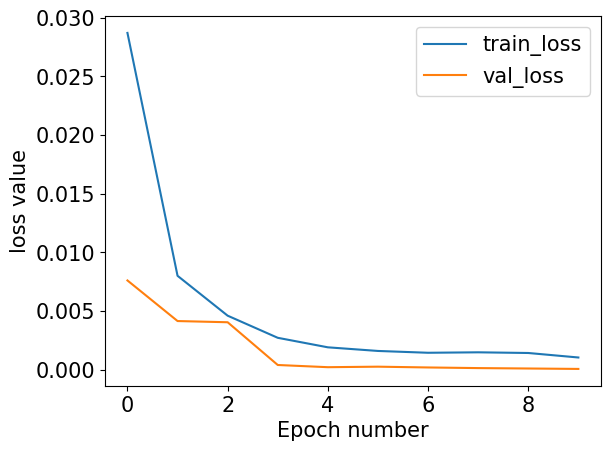

In [ ]:
# plot history
fig,ax = plt.subplots()
ax.plot(history_cnn.history['loss'], label='train_loss')
ax.plot(history_cnn.history['val_loss'], label='val_loss')
ax.set_xlabel('Epoch number')
ax.set_ylabel('loss value')
ax.legend()
plt.show()

In [ ]:
predictions = cnn_model.predict(X_test)
# Assuming 'model' is your trained model for binary classification
threshold = 0.5  # Adjust the threshold as needed
predicted_classes = (predictions > threshold).astype(int)


9375/9375 [==============================] - 16s 2ms/step


In [ ]:
accuracy = accuracy_score(y_test, predicted_classes)
precision = precision_score(y_test, predicted_classes)
recall = recall_score(y_test, predicted_classes)
f1 = f1_score(y_test, predicted_classes)
print(f"Accuracy: {accuracy}")
print(f"precision: {precision}")
print(f"recall: {recall}")
print(f"f1: {f1}")
# Train BiLSTM
# Define and train your BiLSTM model using TensorFlow/Keras

Accuracy: 0.9999699998999997
precision: 0.9998263252349434
recall: 1.0
f1: 0.9999131550760858



# BiLSTM model

In [ ]:
# cleaning the Previous model
from keras import backend as K
K.clear_session()

In [ ]:
# Train BiLSTM
# Define and train your BiLSTM model using TensorFlow/Keras
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Reshape

# Define the model
model = Sequential()
inputs_shape = (X_train.shape[1], X_train.shape[2] )
# Add a Bidirectional LSTM layer
model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape = inputs_shape))

# Add Flatten Layer to change the Output
model.add(Flatten())

# Add Dense layers
model.add(Dense(128, activation='relu'))
model.add(Dense(16, activation='relu'))  # Output layer for binary classification
model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification


# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 3, 128)            38400     
 al)                                                             
                                                                 
 flatten (Flatten)           (None, 384)               0         
                                                                 
 dense (Dense)               (None, 128)               49280     
                                                                 
 dense_1 (Dense)             (None, 16)                2064      
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 89761 (350.63 KB)
Trainable params: 89761 (350.63 KB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [ ]:
history_BiLSTM = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val))

Epoch 1/10
6250/6250 [==============================] - 64s 10ms/step - loss: 0.0017 - accuracy: 0.9995 - val_loss: 2.4140e-07 - val_accuracy: 1.0000
Epoch 2/10
6250/6250 [==============================] - 64s 10ms/step - loss: 6.0097e-08 - accuracy: 1.0000 - val_loss: 8.8026e-09 - val_accuracy: 1.0000
Epoch 3/10
6250/6250 [==============================] - 57s 9ms/step - loss: 3.1560e-09 - accuracy: 1.0000 - val_loss: 1.5247e-09 - val_accuracy: 1.0000
Epoch 4/10
6250/6250 [==============================] - 63s 10ms/step - loss: 9.1670e-10 - accuracy: 1.0000 - val_loss: 5.4671e-10 - val_accuracy: 1.0000
Epoch 5/10
6250/6250 [==============================] - 63s 10ms/step - loss: 5.7955e-10 - accuracy: 1.0000 - val_loss: 6.0472e-10 - val_accuracy: 1.0000
Epoch 6/10
6250/6250 [==============================] - 63s 10ms/step - loss: 5.0331e-10 - accuracy: 1.0000 - val_loss: 5.0165e-10 - val_accuracy: 1.0000
Epoch 7/10
6250/6250 [==============================] - 58s 9ms/step - loss: 4.47

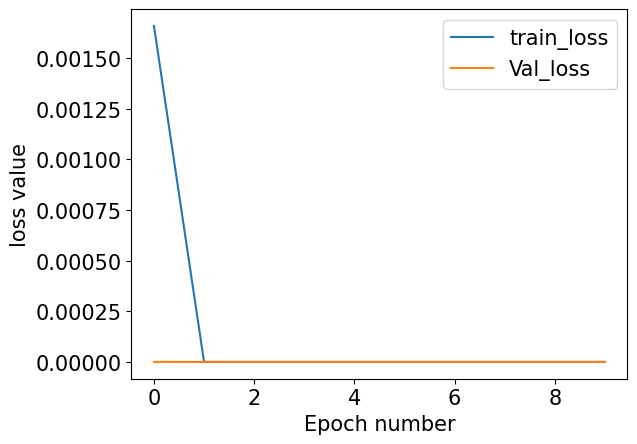

In [ ]:
# plot history
fig,ax = plt.subplots()
ax.plot(history_BiLSTM.history['loss'], label='train_loss')
ax.plot(history_BiLSTM.history['val_loss'], label='Val_loss')
ax.set_xlabel('Epoch number')
ax.set_ylabel('loss value')
ax.legend()
plt.show()

In [ ]:
BiLSTM_model = model

In [ ]:

#BiLSTM_model.save("gdrive/My Drive/GCNIDS_Improvement/BiLSTM_model_Gear.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from tensorflow.keras.models import load_model
BiLSTM_model = load_model("gdrive/My Drive/GCNIDS_Improvement/BiLSTM_model_Gear.h5")

In [ ]:
predictions = BiLSTM_model.predict(X_test)
# Assuming 'model' is your trained model for binary classification
threshold = 0.5  # Adjust the threshold as needed
predicted_classes = (predictions > threshold).astype(int)

9375/9375 [==============================] - 32s 3ms/step


In [ ]:
accuracy = accuracy_score(y_test, predicted_classes)
precision = precision_score(y_test, predicted_classes)
recall = recall_score(y_test, predicted_classes)
f1 = f1_score(y_test, predicted_classes)
print(f"Accuracy: {accuracy}")
print(f"precision: {precision}")
print(f"recall: {recall}")
print(f"f1: {f1}")
# Train BiLSTM
# Define and train your BiLSTM model using TensorFlow/Keras

Accuracy: 1.0
precision: 1.0
recall: 1.0
f1: 1.0


"Accuracy And Loss of BiLSTM and CNN"

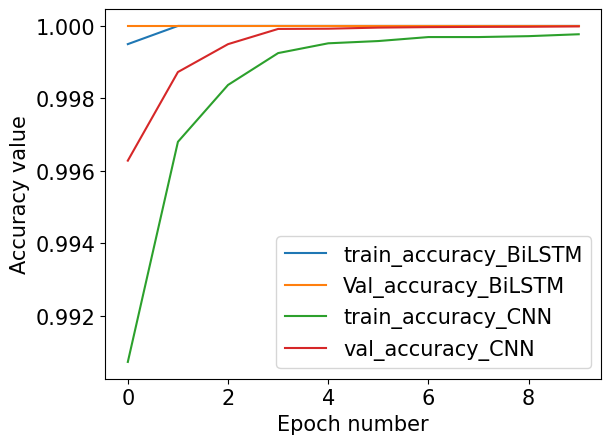

In [ ]:
# plot history
fig,ax = plt.subplots()
ax.plot(history_BiLSTM.history['accuracy'], label='train_accuracy_BiLSTM')
ax.plot(history_BiLSTM.history['val_accuracy'], label='Val_accuracy_BiLSTM')
ax.plot(history_cnn.history['accuracy'], label='train_accuracy_CNN')
ax.plot(history_cnn.history['val_accuracy'], label='val_accuracy_CNN')
ax.set_xlabel('Epoch number')
ax.set_ylabel('Accuracy value')
ax.legend()
plt.show()

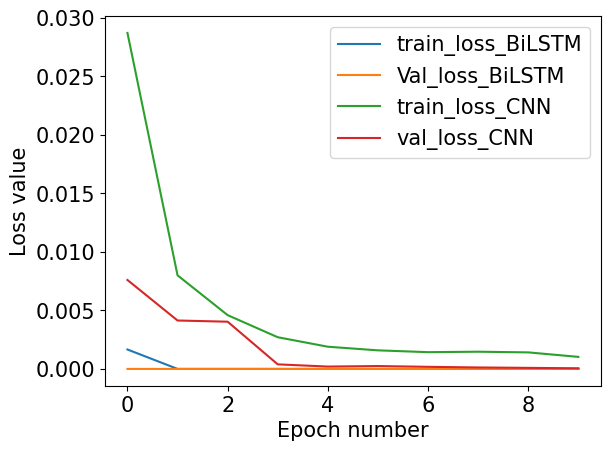

In [ ]:
# plot history
fig,ax = plt.subplots()
ax.plot(history_BiLSTM.history['loss'], label='train_loss_BiLSTM')
ax.plot(history_BiLSTM.history['val_loss'], label='Val_loss_BiLSTM')
ax.plot(history_cnn.history['loss'], label='train_loss_CNN')
ax.plot(history_cnn.history['val_loss'], label='val_loss_CNN')
ax.set_xlabel('Epoch number')
ax.set_ylabel('Loss value')
ax.legend()
plt.show()

# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Create a Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Reshape X_train if needed (if it's currently in shape (399999, 3, 2))
# X_train_reshaped = X_train.reshape(X_train.shape[0], -1)

# Train the model
rf_model.fit(X_train.reshape(X_train.shape[0], -1), y_train)  # Reshape X_train if needed

# Predict on test data
predictions = rf_model.predict(X_test.reshape(X_test.shape[0], -1))  # Reshape X_test if needed

# Evaluate the model (if desired)
accuracy = rf_model.score(X_test.reshape(X_test.shape[0], -1), y_test)  # Reshape X_test if needed
print(f"Accuracy: {accuracy}")

Accuracy: 1.0


In [ ]:


# Assuming rf_model is your trained Random Forest model and predictions are made

# Accuracy
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")

# Precision
precision = precision_score(y_test, predictions)
print(f"Precision: {precision}")

# Recall
recall = recall_score(y_test, predictions)
print(f"Recall: {recall}")

# F1-score
f1 = f1_score(y_test, predictions)
print(f"F1-Score: {f1}")


Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-Score: 1.0


# Meta_Learner Model

In [ ]:
# 3. Generate predictions
cnn_preds = cnn_model.predict(X_val)
lstm_preds = BiLSTM_model.predict(X_val)
rf_preds = rf_model.predict(X_val.reshape(X_val.shape[0], -1))


9375/9375 [==============================] - 29s 3ms/step


In [ ]:
rf_preds = rf_preds.reshape(rf_preds.shape[0],1)
print (cnn_preds.shape)
print (lstm_preds.shape)
print (rf_preds.shape)


(300000, 1)
(300000, 1)
(300000, 1)


In [ ]:
# 4. Create meta-learner dataset
meta_features = np.concatenate((cnn_preds, lstm_preds, rf_preds), axis=1)
meta_dataset = np.concatenate((meta_features, X_val.reshape(X_val.shape[0], -1)), axis=1)  # Assuming features include more than just predictions


In [ ]:
# 5. Train meta-learner
from sklearn.linear_model import LogisticRegression
meta_learner = LogisticRegression()
meta_learner.fit(meta_dataset, y_val)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

# Ensemble Model

In [ ]:
import multiprocessing
# 6. Ensemble prediction
start1 = ti.time()
def Ensemble1(test) :
  cnn_test_preds = cnn_model.predict(test)
  lstm_test_preds = BiLSTM_model.predict(test)
  rf_test_preds = rf_model.predict(test.reshape(test.shape[0], -1))
  rf_test_preds = rf_test_preds.reshape(rf_test_preds.shape[0],1)
  meta_test_features = np.concatenate((cnn_test_preds, lstm_test_preds, rf_test_preds,  X_test.reshape(X_test.shape[0], -1)), axis=1)
  final_prediction = meta_learner.predict(meta_test_features)
  return final_prediction
start1 = ti.time()
final_prediction = Ensemble1 (X_test)
end1 = ti.time()

Time1 = end1 - start1

9375/9375 [==============================] - 30s 3ms/step


In [ ]:
Time1

62.67335748672485

In [ ]:
ytrue = y_test.tolist()
yhat = final_prediction.tolist()

In [ ]:
print (final_prediction.shape)
print (y_test.shape)
print  (f"Number of attacks in Actual data : {ytrue.count(1)}, Number of attack free in Actual data : {ytrue.count(0)} ")
print  (f"Number of attacks in predicted data : {yhat.count(1)}, Number of attack free in predicted data : {yhat.count(0)} ")

(299999,)
(299999,)
Number of attacks in Actual data : 51812, Number of attack free in Actual data : 248187 
Number of attacks in predicted data : 51812, Number of attack free in predicted data : 248187 


In [ ]:
# define our Confusion matrix beased on our info
def conf(yTrue,yPred):
  tp,tn,fp,fn = 0,0,0,0
  for i in range(len(yTrue)):
    if yTrue[i] == yPred[i] and yTrue[i] == 1:
      tp= tp+1

    elif yTrue[i] == yPred[i] and yTrue[i] == 0:
      tn = tn+1
    elif yTrue[i] == 0 and yPred[i] == 1:
      fp=fp+1
    else:
      fn=fn+1


  return np.array([[tp,fp],[fn,tn]])



my_conf = conf(ytrue,yhat)
print (f'TP:{my_conf[0][0]}')
print (f'FP:{my_conf[0][1]}')
print (f'FN:{my_conf[1][0]}')
print (f'TN:{my_conf[1][1]}')


TP:51812
FP:0
FN:0
TN:248187


In [ ]:
# Accuracy
accuracy = accuracy_score(y_test, final_prediction)
print(f"Accuracy: {accuracy}")

# Precision
precision = precision_score(y_test, final_prediction)
print(f"Precision: {precision}")

# Recall
recall = recall_score(y_test, final_prediction)
print(f"Recall: {recall}")

# F1-score
f1 = f1_score(y_test, final_prediction)
print(f"F1-Score: {f1}")


Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-Score: 1.0


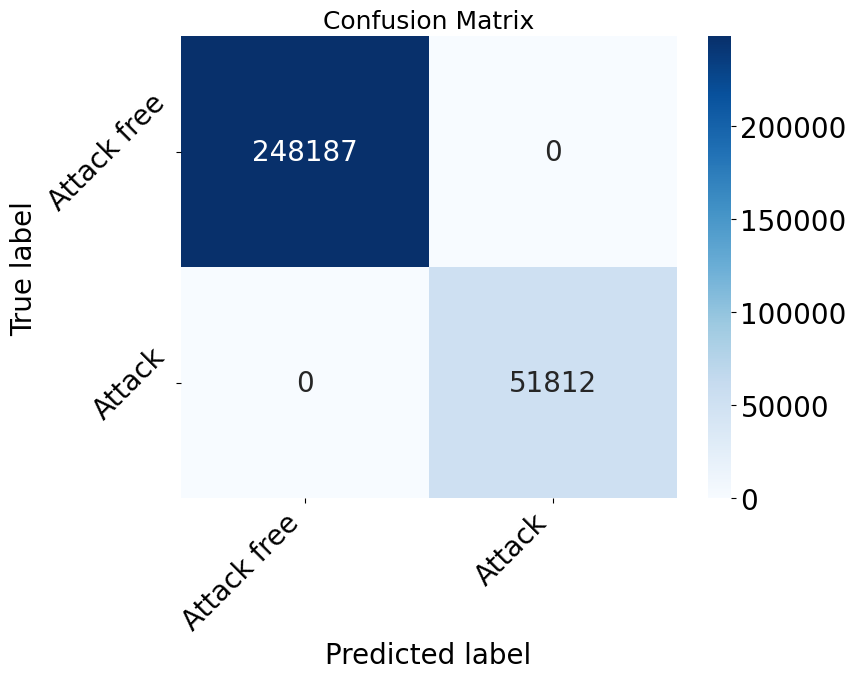

In [ ]:
# Confusion matrix
import seaborn as sns
conf_matrix = confusion_matrix(y_test, final_prediction)

# Display the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Attack free', 'Attack'],
            yticklabels=['Attack free', 'Attack'])
plt.rcParams['font.size'] = 15
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.yticks(rotation = 45)
plt.xticks(rotation = 45, ha = 'right')
plt.title('Confusion Matrix')
plt.show()